In [537]:
import keras
print(keras.__version__)

3.3.3.dev2024062103


In [538]:
import numpy as np
import matplotlib.pyplot as plt


In [539]:
def conical_surface(eccentricity, num_points=100):
    if eccentricity < 0:
        raise ValueError("Eccentricity must be non-negative.")
    
    t = np.linspace(-np.pi, np.pi, num_points)
    a =1.0
    if eccentricity < 1:  # Ellipse
        b = a * np.sqrt(1 - eccentricity**2)
        x = a * np.cos(t)
        y = b * np.sin(t)
    elif eccentricity == 1:  # Parabola
        x = 2 * a * t
        y = t**2 
    else:  # Hyperbola
        b = a * np.sqrt(eccentricity**2 - 1)
        y = a * np.cosh(t)
        x = b * np.sinh(t)
    
    return x, y

In [540]:
e=1.1
x,y = conical_surface(e,1000)

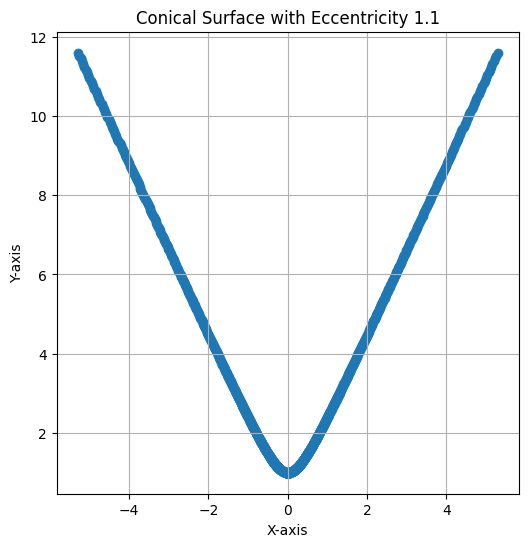

In [541]:
plt.figure(figsize=(6, 6))
plt.scatter(x, y)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'Conical Surface with Eccentricity {e}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [542]:
def generate_elipses(e,a=1,num_points=100):
    t = np.linspace(-np.pi, np.pi, num_points)
    
    b = a * np.sqrt(1 - e**2)
    x = a * np.cos(t)
    y = b * np.sin(t)
    return x,y

In [543]:
def apply_rotation_translation(x,y,xt=0,yt=0,angle_rad=0):
    xf = xt + x * np.cos(angle_rad) - y * np.sin(angle_rad)
    yf = yt + x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return xf,yf

[]

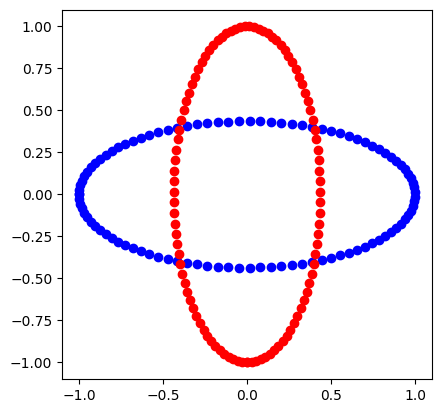

In [544]:
testex,testey=generate_elipses(0.9,1,100)
tx,ty=apply_rotation_translation(testex,testey,0,0,np.pi/2)
plt.scatter(testex,testey,color="blue")
plt.scatter(tx,ty,color="red")
plt.gca().set_aspect('equal', adjustable='box')

plt.plot()

In [545]:
import random
x_values = []
y_values = []
samples=10000
num_points=100
e_values=np.random.rand(samples)
a_values=np.ones(samples)##100*np.random.rand(samples)

angle_values=0*np.pi*np.random.rand(samples)#2*np.pi*np.random.rand(samples)
xt_values=0*100*np.random.rand(samples)
yt_values=0*100*np.random.rand(samples)

for e,a,angle,xt,yt in zip(e_values,a_values,angle_values,xt_values,yt_values):
    x,y=generate_elipses(e,a,num_points)
    xf,yf=apply_rotation_translation(x,y,xt,yt,angle)
    x_values.append(xf)  # Append x values to list
    y_values.append(yf)  # Append y values to list



In [546]:
#lets add noise
x_noise=[]
y_noise=[]
for a,x in zip(a_values,x_values):
    noisex= np.random.normal(loc=0,scale=np.sqrt(a)*0,size=num_points)
    x_noise.append(noisex+x)
for a,y in zip(a_values,y_values):
    noisey= np.random.normal(loc=0,scale=np.sqrt(a)*0,size=num_points)
    y_noise.append(noisey+y)

#x_noise=x_values+a_values*noisex
#y_noise=y_values*a_values*noisey


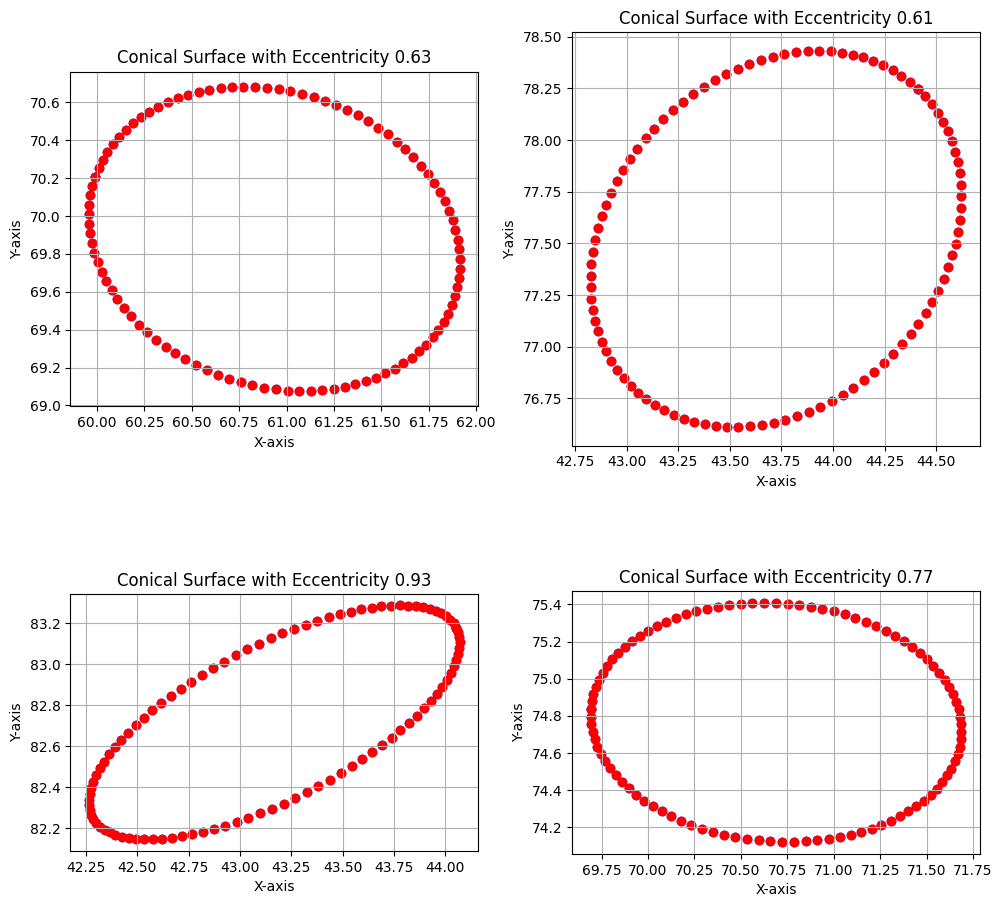

In [547]:
num_plots = 4
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Randomly choose 4 indices to plot
indices_to_plot = np.random.choice(samples, 4, replace=False)

# Plotting each subplot
for i, idx in enumerate(indices_to_plot):
    row = i // 2  # Determine row index (0 or 1)
    col = i % 2   # Determine column index (0 or 1)
    
    axs[row, col].scatter(x_values[idx], y_values[idx],color='blue')
    axs[row, col].scatter(x_noise[idx], y_noise[idx],color='red')

    axs[row, col].set_aspect('equal', adjustable='box')
    axs[row, col].set_title(f'Conical Surface with Eccentricity {e_values[idx]:.2f}')
    axs[row, col].set_xlabel('X-axis')
    axs[row, col].set_ylabel('Y-axis')
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

In [548]:
#rede neural
#import tensorflow as tf
#from tensorflow import keras
from keras import models,layers,initializers

In [549]:
#input_data = [(x_noise[i], y_noise[i]) for i in range(len(x_noise))]
#input_data_flat = input_data.reshape((input_data.shape[0], -1))
input_data = np.concatenate([x_noise,y_noise],1)
output_data = np.column_stack([e_values])
print(input_data.shape)
print(e_values.shape)
print(output_data.shape)
print(len(input_data[0]))



(10000, 200)
(10000,)
(10000, 1)
200


In [550]:
def prepare_data(x,y):
    return np.concatenate([x_noise,y_noise],1)

In [551]:
# Criar o modelo sequencial
model = models.Sequential(name="my_neural")
model.add(layers.Input(shape=(2 * num_points,)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1000, activation="relu", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  # Adicionando Dropout
model.add(layers.Dense(500, activation="tanh", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  # Adicionando Dropout
model.add(layers.Dense(1000, activation="relu", kernel_initializer="he_normal"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  # Adicionando Dropout
model.add(layers.Dense(1, activation="linear"))  # Saída com duas unidades, uma para 'a' e outra para 'e'

model.compile(optimizer="adam",loss="mse",metrics=["mean_squared_error"])

model.summary()


Model: "my_neural"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_75          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1000)           │       201,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 500)            │         2,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1000)           │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,214,301 (4.63 MB)

 Trainable params: 1,208,901 (4.61 MB)

 Non-trainable params: 5,400 (21.09 KB)

In [552]:
#separando os dados
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(input_data,output_data,random_state=42,test_size=0.5)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



In [553]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train,y_train,epochs=50,batch_size=100,validation_data=(x_test,y_test),callbacks=[early_stopping])

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.5238 - mean_squared_error: 3.5238 - val_loss: 0.2752 - val_mean_squared_error: 0.2752
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.5423 - mean_squared_error: 1.5423 - val_loss: 0.1490 - val_mean_squared_error: 0.1490
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8943 - mean_squared_error: 0.8943 - val_loss: 0.1416 - val_mean_squared_error: 0.1416
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.5670 - mean_squared_error: 0.5670 - val_loss: 0.1266 - val_mean_squared_error: 0.1266
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3608 - mean_squared_error: 0.3608 - val_loss: 0.0968 - val_mean_squared_error: 0.0968
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2359 - mean_squared_error: 0.2359 - val_loss: 0.0916 - val_mean_squared_error: 0.0916
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1775 - mean_squared_error: 0.1775 - val_loss: 0.0893 - va

In [554]:
# Accessing the training loss history
training_loss = history.history['loss']

# Accessing the validation loss history
validation_loss = history.history['val_loss']

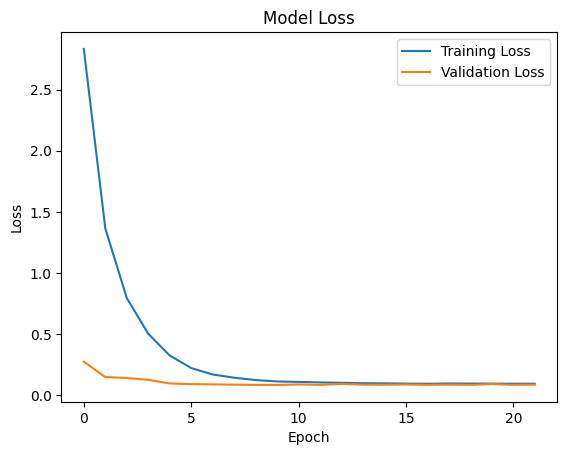

In [555]:
# Plot training & validation loss values
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [558]:
e=0.23
a=1
x_teste,y_teste = generate_elipses(e,a,100)
teste=np.concatenate([x_teste,y_teste])
# Reshape teste to match the expected input shape of your model
teste = np.expand_dims(teste, axis=0)  # Shape will be (1, 200)
print(model.predict(scaler.transform(teste)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.53203773]]


In [562]:
index=45
print(y_test[index])

print(model.predict(np.expand_dims(x_test[index], axis=0)))

[0.02248038]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[0.54201543]]
